[INFO] Using: 01a_normalized
[INFO] Loaded 8 extra terms from config/medical_terms.yml
✅ Domain cleanup complete.
Summary → /Users/balijepalli/Documents/GitHub/entheory-ai/notebooks/outputs/run_001/02_cleaned/_qa_cleanup.csv
Plot → /Users/balijepalli/Documents/GitHub/entheory-ai/notebooks/outputs/run_001/02_cleaned/_qa_cleanup_summary.png


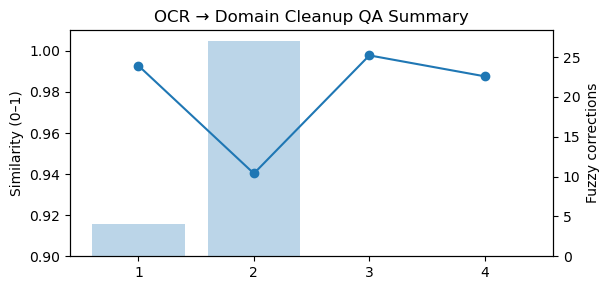

In [3]:
# %% [markdown]
# # 02 — Domain cleanup with biomedical normalization
# Input  : outputs/run_001/01a_normalized or 01_blocks (fallback)
# Output : outputs/run_001/02_cleaned/page_*_blocks.domain.json
# What:
#   - safe character fixes, spacing, dashes/bullets
#   - dictionary corrections (YAML-extendable)
#   - fuzzy normalization against medical vocab seed
#   - optional SciSpaCy + QuickUMLS annotations (no text replacement by default)
# QA:
#   - similarity(orig→clean), corrections count per page
#   - plot saved as _qa_cleanup_summary.png

# %%
import re, json, difflib, yaml, os
from pathlib import Path
from typing import Dict, Any, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt

RUN_ROOT = Path("outputs/run_001").resolve()
IN_DIRS  = [RUN_ROOT/"01a_normalized", RUN_ROOT/"01_blocks"]
OUT_DIR  = RUN_ROOT/"02_cleaned"
OUT_DIR.mkdir(parents=True, exist_ok=True)
QA_DIR   = OUT_DIR/"_qa"; QA_DIR.mkdir(exist_ok=True)

# Try SciSpaCy / QuickUMLS (optional)
try:
    import spacy
    _NLP = None; _LINKER = None
    for m in ["en_core_sci_lg","en_ner_bc5cdr_md","en_ner_bionlp13cg_md"]:
        try:
            _NLP = spacy.load(m); break
        except Exception: pass
    if _NLP is not None:
        try:
            _NLP.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": "umls"})
            _LINKER = _NLP.get_pipe("scispacy_linker")
        except Exception: _LINKER = None
except Exception:
    _NLP = None; _LINKER = None

quickumls_path = os.environ.get("QUICKUMLS_PATH","")
_MATCHER = None
if quickumls_path:
    try:
        from quickumls import QuickUMLS
        _MATCHER = QuickUMLS(quickumls_path)
    except Exception:
        _MATCHER = None

def find_pages():
    for d in IN_DIRS:
        ps = sorted(d.glob("page_*_blocks*.json"))
        if ps:
            print("[INFO] Using:", d.name)
            return ps, d
    raise FileNotFoundError("No page_* JSONs in 01a_normalized or 01_blocks")

pages, SRC = find_pages()

# Built-in dictionary (extend with YAML if present)
BUILTIN_MAP = {
    "toabeculas": "trabeculae",
    "trabeculas": "trabeculae",
    "trabaculae": "trabeculae",
    "fotymoyphoys": "polymorphous",
    "palato": "palate",
    "pala": "palate",
    "comozd": "composed",
    "necrosls": "necrosis",
    "microscoplc": "microscopic",
    "cribriforme": "cribriform",
}
yml = Path("config/medical_terms.yml")
if yml.exists():
    ext = yaml.safe_load(yml.read_text(encoding="utf-8")) or {}
    if isinstance(ext, dict):
        BUILTIN_MAP.update(ext)
        print(f"[INFO] Loaded {len(ext)} extra terms from {yml}")

VOCAB = sorted(set(BUILTIN_MAP.values()).union({
    "histopathology","specimen","gross","microscopic","impression",
    "pleomorphic","trabeculae","necrosis","cribriform","carcinoma",
    "fibrosis","lymphocyte","ductal","invasive","lobular","metastatic",
    "biopsy","stroma","adenocarcinoma","immunohistochemistry","ki67","her2","er","pr"
}))
STOPWORDS = {"and","the","with","for","from","this","that","of","to","in","at","by","is","are"}

def seq_sim(a: str, b: str) -> float:
    return difflib.SequenceMatcher(None, a, b).ratio()

def apply_rules(t: str)->str:
    t = re.sub(r"[•·∙●]", ".", t)
    t = re.sub(r"[–—−]+", "-", t)
    t = re.sub(r"[×✕✖]", "x", t)
    t = re.sub(r"\s{2,}", " ", t)
    return t.strip()

def apply_dictionary(t: str, mp: Dict[str,str])->Tuple[str,int,Dict[str,str]]:
    count, changes = 0, {}
    for wrong, right in sorted(mp.items(), key=lambda kv: len(kv[0]), reverse=True):
        pat = rf"\b{re.escape(wrong)}\b"
        if re.search(pat, t, flags=re.I):
            t = re.sub(pat, right, t, flags=re.I)
            count += 1; changes[wrong]=right
    return t,count,changes

def apply_fuzzy(t: str, vocab: List[str], cutoff=0.86, max_corr=200)->Tuple[str,int,Dict[str,str]]:
    toks = re.findall(r"[A-Za-z][A-Za-z\-]{3,}", t)
    uniq = sorted({w.lower() for w in toks if w.lower() not in STOPWORDS})
    repl, ct = {}, 0
    for w in uniq:
        hit = difflib.get_close_matches(w, vocab, n=1, cutoff=cutoff)
        if hit:
            repl[w]=hit[0]; ct+=1
            if ct>=max_corr: break
    out = t
    for w,r in repl.items():
        out = re.sub(rf"\b{re.escape(w)}\b", r, out, flags=re.I)
    return out, len(repl), repl

def scispacy_annot(t: str):
    if _NLP is None: return []
    out=[]
    try:
        doc=_NLP(t)
        for ent in doc.ents:
            item={"text":ent.text,"label":ent.label_}
            if _LINKER is not None and ent._.kb_ents:
                cui,score = ent._.kb_ents[0]
                kb = _LINKER.kb.cui_to_entity.get(cui)
                if kb: item.update({"cui":cui,"canon":kb.canonical_name,"score":float(score)})
            out.append(item)
    except Exception:
        pass
    return out

def quickumls_hits(t: str):
    if _MATCHER is None: return []
    res=[]
    try:
        matches=_MATCHER.match(t, best_match=True, ignore_syntax=False)
        for group in matches:
            m=group[0]
            res.append({"ngram":m["ngram"],"term":m["term"],"cui":m["cui"],"similarity":float(m["similarity"])})
    except Exception:
        pass
    return res

def chars(blocks): return sum(len((b.get("text") or "")) for b in blocks)

rows = []
for p in pages:
    data = json.loads(p.read_text(encoding="utf-8"))
    cleaned=[]
    sims=[]; dict_ct=fuzzy_ct=rules_ct=ents_ct=cui_ct=q_ct=0

    for b in data:
        t0 = (b.get("text") or "").strip()
        if not t0: 
            continue
        t1 = apply_rules(t0);                     rules_ct += int(t1!=t0)
        t2, dc, _ = apply_dictionary(t1, BUILTIN_MAP); dict_ct += dc
        t3, fc, _ = apply_fuzzy(t2, VOCAB, 0.86, 200); fuzzy_ct += fc
        ents = scispacy_annot(t3); ents_ct += len(ents); cui_ct += sum(1 for e in ents if "cui" in e)
        qhits = quickumls_hits(t3); q_ct += len(qhits)

        nb = dict(b)
        nb["text_cleaned"] = t3
        nb["norm_meta"] = {"rules_changed":int(t1!=t0),"dict_corr":dc,"fuzzy_corr":fc,
                           "scispacy_ents":len(ents),"quickumls_hits":len(qhits)}
        cleaned.append(nb)
        sims.append(seq_sim(t0, t3))

    # save page
    OUT_DIR.joinpath(f"{p.stem}.domain.json").write_text(json.dumps(cleaned, ensure_ascii=False, indent=2), encoding="utf-8")

    if sims:
        rows.append({
            "page": int(re.search(r"page_(\d+)_", p.name).group(1)) if re.search(r"page_(\d+)_", p.name) else p.name,
            "blocks": len(cleaned),
            "similarity_mean": round(sum(sims)/len(sims),4),
            "dict_corrections": dict_ct,
            "fuzzy_corrections": fuzzy_ct,
            "rules_changed": rules_ct,
            "scispacy_ents": ents_ct,
            "scispacy_cuis": cui_ct,
            "quickumls_hits": q_ct
        })
        # also per-page block detail
        pd.DataFrame(cleaned).to_json(QA_DIR/f"{p.stem}_cleaned_preview.json", orient="records", indent=2)

# summary + plot
df = pd.DataFrame(rows).sort_values("page")
df.to_csv(OUT_DIR/"_qa_cleanup.csv", index=False)
print("✅ Domain cleanup complete.\nSummary →", OUT_DIR/"_qa_cleanup.csv")

if len(df):
    fig, ax1 = plt.subplots(figsize=(6.2,3))
    ax1.plot(df["page"].astype(str), df["similarity_mean"], marker="o")
    ax1.set_ylabel("Similarity (0–1)"); ax1.set_ylim(0.90, 1.01)
    ax2 = ax1.twinx()
    ax2.bar(df["page"].astype(str), df["fuzzy_corrections"], alpha=0.30, label="Fuzzy corrections")
    ax2.set_ylabel("Fuzzy corrections")
    plt.title("OCR → Domain Cleanup QA Summary")
    fig.tight_layout()
    figpath = OUT_DIR/"_qa_cleanup_summary.png"
    plt.savefig(figpath, dpi=150)
    print("Plot →", figpath)
